Starting Step 1: Build CCGraph
Completed Step 1: Build CCGraph
Step 1: Build CCGraph took 0.3494 seconds
Starting Step 2: Get Density Dists BB
Completed Step 2: Get Density Dists BB
Step 2: Get Density Dists BB took 7.3147 seconds
Starting Step 3: Get Y
Completed Step 3: Get Y
Step 3: Get Y took 0.5606 seconds
CPF Clustering:
Number of clusters found: 175
Total Time taken: 8.22 seconds
Adjusted Rand Index (ARI): -0.000132
Adjusted Mutual Information (AMI): -0.005596
Silhouette Score: 0.620144
Davies-Bouldin Index: 2.343117


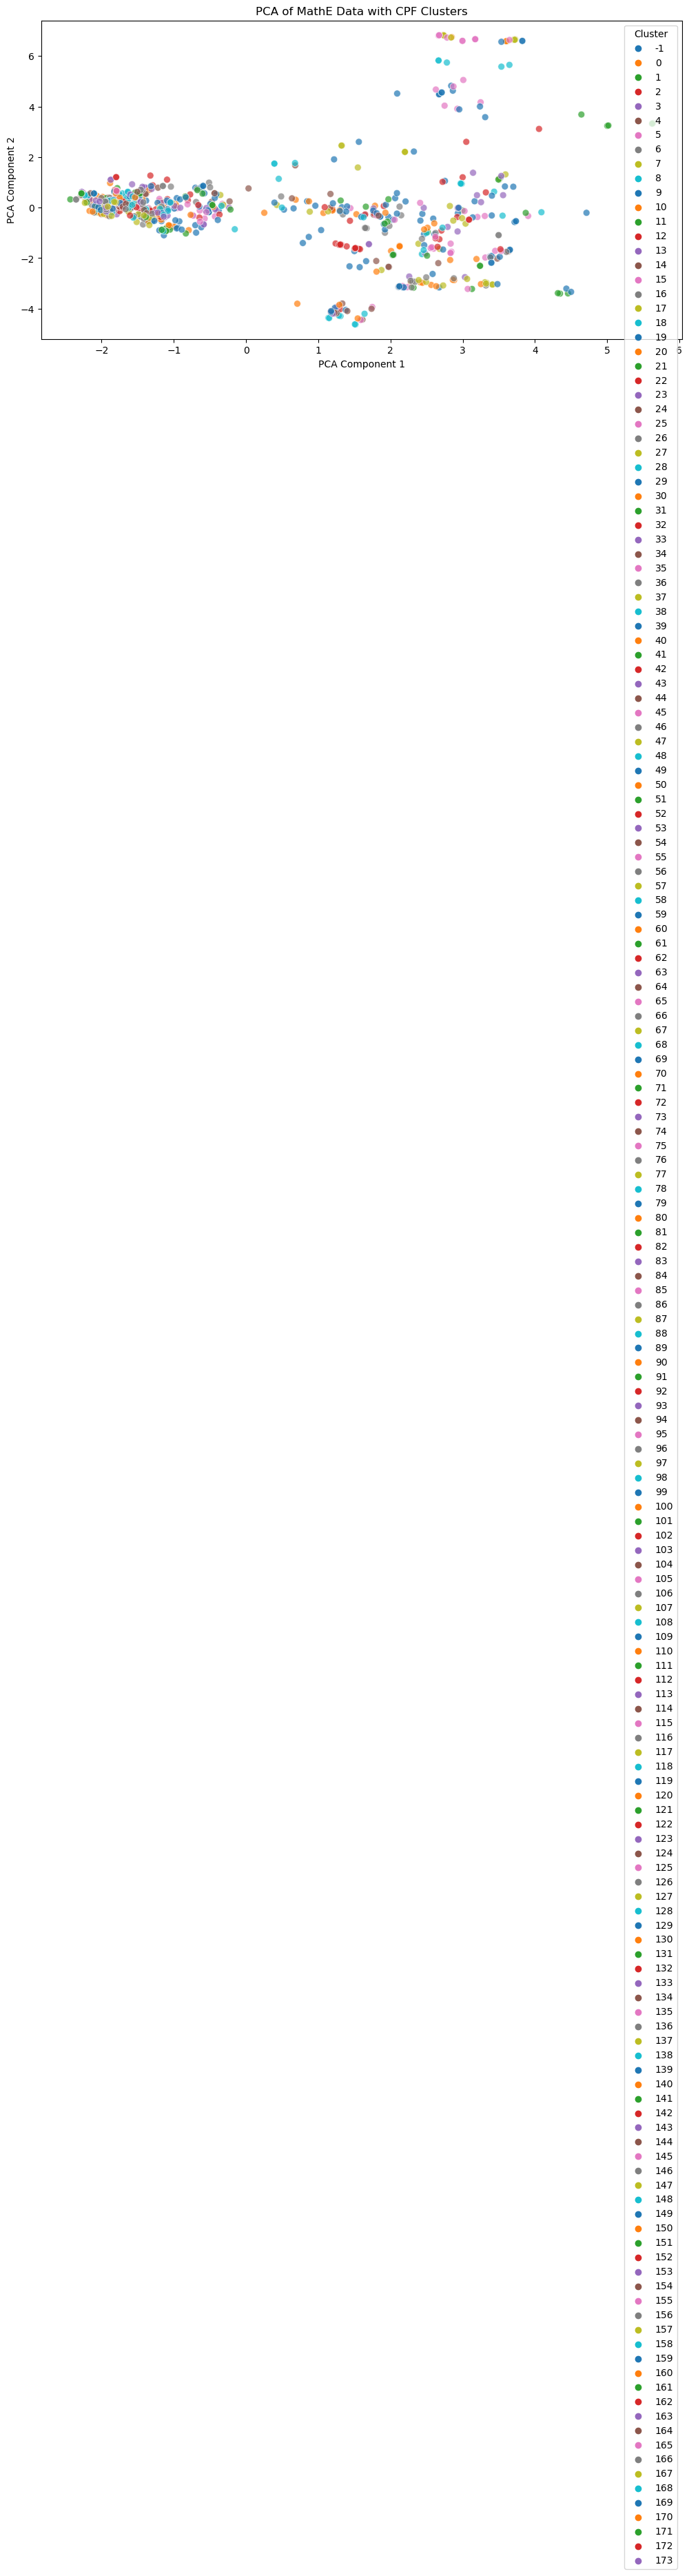

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import time
import gc
import multiprocessing as mp
import itertools
from sklearn.metrics.pairwise import euclidean_distances

# utils module
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def density_broad_search_star(a_b):
    """Wrapper for multiprocessing to call density_broad_search."""
    try:
        return euclidean_distances(a_b[1], a_b[0])
    except Exception as e:
        raise Exception(e)

# CPF functions
def build_CCgraph(X, k, cutoff, n_jobs):
    print("Starting Step 1: Build CCGraph")
    n = X.shape[0]
    kdt = NearestNeighbors(n_neighbors=k, metric='euclidean', n_jobs=n_jobs, algorithm='kd_tree').fit(X)
    CCmat = kdt.kneighbors_graph(X, mode='distance')
    distances, _ = kdt.kneighbors(X)
    knn_radius = distances[:, k-1]
    CCmat = CCmat.minimum(CCmat.T)
    _, components = scipy.sparse.csgraph.connected_components(CCmat, directed=False, return_labels=True)
    comp_labs, comp_count = np.unique(components, return_counts=True)
    outlier_components = comp_labs[comp_count <= cutoff]
    nanidx = np.in1d(components, outlier_components)
    components = components.astype(float)
    if sum(nanidx) > 0:
        components[nanidx] = np.nan
    print("Completed Step 1: Build CCGraph")
    return components, CCmat, knn_radius

def get_density_dists_bb(X, k, components, knn_radius, n_jobs):
    print("Starting Step 2: Get Density Dists BB")
    best_distance = np.empty((X.shape[0]))
    best_distance[:] = np.nan
    big_brother = np.empty((X.shape[0]))
    big_brother[:] = np.nan
    comps = np.unique((components[~np.isnan(components)])).astype(int)
    ps = np.zeros((1, 2))
    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        kcc = min(k, nc-1)
        kdt = NearestNeighbors(n_neighbors=kcc, metric='euclidean', n_jobs=n_jobs, algorithm='kd_tree').fit(X[cc_idx, :])
        distances, neighbors = kdt.kneighbors(X[cc_idx, :])
        cc_knn_radius = knn_radius[cc_idx]
        cc_best_distance = np.empty((nc))
        cc_big_brother = np.empty((nc))
        cc_radius_diff = cc_knn_radius[:, np.newaxis] - cc_knn_radius[neighbors]
        rows, cols = np.where(cc_radius_diff > 0)
        rows, unidx = np.unique(rows, return_index=True)
        del cc_radius_diff
        gc.collect()
        cols = cols[unidx]
        cc_big_brother[rows] = neighbors[rows, cols]
        cc_best_distance[rows] = distances[rows, cols]
        search_idx = list(np.setdiff1d(list(range(X[cc_idx, :].shape[0])), rows))
        ps = np.vstack((ps, [len(cc_idx), len(search_idx)/len(cc_idx)]))
        for indx_chunk in chunks(search_idx, 100):
            search_radius = cc_knn_radius[indx_chunk]
            GT_radius = cc_knn_radius < search_radius[:, np.newaxis]
            if any(np.sum(GT_radius, axis=1) == 0):
                max_i = [i for i in range(GT_radius.shape[0]) if np.sum(GT_radius[i, :]) == 0]
                if len(max_i) > 1:
                    for max_j in max_i[1:len(max_i)]:
                        GT_radius[max_j, indx_chunk[max_i[0]]] = True
                max_i = max_i[0]
                cc_big_brother[indx_chunk[max_i]] = indx_chunk[max_i]
                cc_best_distance[indx_chunk[max_i]] = np.inf
                del indx_chunk[max_i]
                GT_radius = np.delete(GT_radius, max_i, 0)
            
            GT_distances = ([X[cc_idx[indx_chunk[i]], np.newaxis], X[cc_idx[GT_radius[i, :]], :]] for i in range(len(indx_chunk)))
            if (GT_radius.shape[0] > 50):
                try:
                    pool = mp.Pool(processes=n_jobs)
                    N = 25
                    distances = []
                    i = 0
                    while True:
                        distance_comp = pool.map(density_broad_search_star, itertools.islice(GT_distances, N))
                        if distance_comp:
                            distances.append(distance_comp)
                            i += 1
                        else:
                            break
                    distances = [dis_pair for dis_list in distances for dis_pair in dis_list]
                    argmin_distance = [np.argmin(l) for l in distances]
                    pool.terminate()
                except Exception as e:
                    print("POOL ERROR: " + str(e))
                    pool.close()
                    pool.terminate()
            else:
                distances = list(map(density_broad_search_star, list(GT_distances)))
                argmin_distance = [np.argmin(l) for l in distances]
            
            for i in range(GT_radius.shape[0]):
                cc_big_brother[indx_chunk[i]] = np.where(GT_radius[i, :] == 1)[0][argmin_distance[i]]
                cc_best_distance[indx_chunk[i]] = distances[i][argmin_distance[i]]
        
        big_brother[cc_idx] = [cc_idx[i] for i in cc_big_brother.astype(int)]
        best_distance[cc_idx] = cc_best_distance
    
    print("Completed Step 2: Get Density Dists BB")
    return best_distance, big_brother

def get_y(CCmat, components, knn_radius, best_distance, big_brother, rho, alpha, d):
    print("Starting Step 3: Get Y")
    n = components.shape[0]
    y_pred = np.repeat(-1, n)
    peaks = []
    n_cent = 0
    comps = np.unique((components[~np.isnan(components)])).astype(int)
    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        tested = []
        cc_knn_radius = knn_radius[cc_idx]
        cc_best_distance = best_distance[cc_idx]
        index = np.argsort(cc_idx)
        sorted_x = cc_idx[index]
        sorted_index = np.searchsorted(sorted_x, big_brother[cc_idx])
        cc_big_brother = np.take(index, sorted_index, mode="clip")
        not_tested = np.ones(nc, dtype=bool)
        peaked = cc_best_distance / cc_knn_radius
        peaked[(cc_best_distance == 0) * (cc_knn_radius == 0)] = np.inf
        cc_centers = [np.argmax(peaked)]
        not_tested[cc_centers[0]] = False
        while True:
            if np.sum(not_tested) == 0:
                break
            subset_idx = np.argmax(peaked[not_tested])
            prop_cent = np.arange(peaked.shape[0])[not_tested][subset_idx]
            tested.append(np.arange(peaked.shape[0])[not_tested][subset_idx])
            CCmat_level = CCmat[cc_idx, :][:, cc_idx]
            if cc_knn_radius[prop_cent] > max(cc_knn_radius[~not_tested]):
                cc_level_set = np.where(cc_knn_radius <= cc_knn_radius[prop_cent])[0]
                CCmat_check = CCmat_level[cc_level_set, :][:, cc_level_set]
                n_cc, _ = scipy.sparse.csgraph.connected_components(CCmat_check, directed=False, return_labels=True)
                if n_cc == 1:
                    break
            if cc_knn_radius[prop_cent] > 0:
                v_cutoff = cc_knn_radius[prop_cent] / (rho ** (1 / d))
                e_cutoff = cc_knn_radius[prop_cent] / alpha
                e_mask = np.abs(CCmat_level.data) > e_cutoff
                CCmat_level.data[e_mask] = 0
                CCmat_level.eliminate_zeros()
                cc_cut_idx = np.where(cc_knn_radius < v_cutoff)[0]
                CCmat_level = CCmat_level[cc_cut_idx, :][:, cc_cut_idx]
            else:
                v_cutoff = cc_knn_radius[prop_cent] / (rho ** (1 / d))
                e_cutoff = cc_knn_radius[prop_cent] / alpha
                e_mask = np.abs(CCmat_level.data) >= e_cutoff
                CCmat_level.data[e_mask] = 0
                CCmat_level.eliminate_zeros()
                cc_cut_idx = np.where(cc_knn_radius <= v_cutoff)[0]
                CCmat_level = CCmat_level[cc_cut_idx, :][:, cc_cut_idx]
            _, cc_labels = scipy.sparse.csgraph.connected_components(CCmat_level, directed=False, return_labels=True)
            del CCmat_level
            gc.collect()
            center_comp = cc_labels[np.isin(cc_cut_idx, cc_centers)]
            prop_cent_comp = cc_labels[np.where(cc_cut_idx == prop_cent)[0]]
            if np.isin(prop_cent_comp, center_comp):
                if peaked[prop_cent] == min(peaked[cc_centers]):
                    cc_centers.append(prop_cent)
                    not_tested[prop_cent] = False
                    continue
                else:
                    break
            else:
                cc_centers.append(prop_cent)
                not_tested[prop_cent] = False

        cc_centers = np.array(cc_centers)
        peaks.extend(cc_idx[cc_centers])
        BBTree = np.zeros((nc, 2))
        BBTree[:, 0] = range(nc)
        BBTree[:, 1] = cc_big_brother
        BBTree[cc_centers, 1] = cc_centers
        BBTree = BBTree.astype(int)
        Clustmat = scipy.sparse.csr_matrix((np.ones((nc)), (BBTree[:, 0], BBTree[:, 1])), shape=(nc, nc))
        n_clusts, cc_y_pred = scipy.sparse.csgraph.connected_components(Clustmat, directed=True, return_labels=True)
        cc_y_pred += n_cent
        n_cent += n_clusts
        y_pred[cc_idx] = cc_y_pred

    print("Completed Step 3: Get Y")
    return y_pred


class CPFcluster:
    def __init__(self, k, rho=0.4, alpha=1, n_jobs=1, remove_duplicates=False, cutoff=1):
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.remove_duplicates = remove_duplicates
        self.cutoff = cutoff

    def fit(self, X):
        if type(X) is not np.ndarray:
            raise ValueError("X must be an n x d numpy array.")
        
        if self.remove_duplicates:
            X = np.unique(X, axis=0)
        
        n, d = X.shape
        if self.k > n:
            raise ValueError("k cannot be larger than n.")
        
        # Step 1: Build CCGraph
        start_time = time.time()
        self.components, self.CCmat, knn_radius = build_CCgraph(X, self.k, self.cutoff, self.n_jobs)
        step1_time = time.time() - start_time
        print(f"Step 1: Build CCGraph took {step1_time:.4f} seconds")
        
        # Step 2: Get Density Dists BB
        start_time = time.time()
        best_distance, big_brother = get_density_dists_bb(X, self.k, self.components, knn_radius, self.n_jobs)
        step2_time = time.time() - start_time
        print(f"Step 2: Get Density Dists BB took {step2_time:.4f} seconds")
        
        # Step 3: Get Y
        start_time = time.time()
        self.labels_ = get_y(self.CCmat, self.components, knn_radius, best_distance, big_brother, self.rho, self.alpha, d)
        step3_time = time.time() - start_time
        print(f"Step 3: Get Y took {step3_time:.4f} seconds")


# Load the dataset
file_path = 'MathE_dataset.csv'
data = pd.read_csv(file_path, delimiter=';', encoding='ISO-8859-1')

# Reduce the dataset size significantly for testing
reduced_data = data.sample(frac=0.10, random_state=42)  # Use 10% of the data for testing

# Define features and remove non-Likert scale attributes
features = reduced_data.drop(columns=['Type of Answer'])

# One-hot encode categorical variables
features = pd.get_dummies(features, drop_first=True)

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(features)

# Add synthetic labels for ARI and AMI calculations
np.random.seed(42)
true_labels = np.random.randint(0, 7, size=data_normalized.shape[0])  # Assuming 7 clusters for synthetic labels

# Function to plot PCA results
def plot_pca_2d(data, labels, title, file_name):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='tab10', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.savefig(file_name)
    plt.show()

# Function to calculate and print clustering metrics
def print_clustering_metrics(true_labels, predicted_labels):
    # Removing NaN entries
    valid_indices = ~np.isnan(predicted_labels)
    true_labels = true_labels[valid_indices]
    predicted_labels = predicted_labels[valid_indices]
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    silhouette_avg = silhouette_score(data_normalized[valid_indices], predicted_labels)
    davies_bouldin = davies_bouldin_score(data_normalized[valid_indices], predicted_labels)
    
    print(f'Adjusted Rand Index (ARI): {ari:.6f}')
    print(f'Adjusted Mutual Information (AMI): {ami:.6f}')
    print(f'Silhouette Score: {silhouette_avg:.6f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.6f}')

# Use the CPF cluster
cpf_model = CPFcluster(k=10, rho=0.4, n_jobs=1)

# Measure time taken
start_time = time.time()
cpf_model.fit(data_normalized)
end_time = time.time()

predicted_labels_cpf = cpf_model.labels_

# Calculate number of clusters found
num_clusters = len(np.unique(predicted_labels_cpf[~np.isnan(predicted_labels_cpf)]))

print("CPF Clustering:")
print(f"Number of clusters found: {num_clusters}")
print(f"Total Time taken: {end_time - start_time:.2f} seconds")

# Calculate and print clustering metrics
print_clustering_metrics(true_labels, predicted_labels_cpf)

# Plot PCA results
plot_pca_2d(data_normalized, predicted_labels_cpf, 'PCA of MathE Data with CPF Clusters', 'pca_clusters_CPF.png')

            